## AutoEncoders on MNIST

Autoencoders are a key tool in understanding the advance topics of deep learning as they give us a low-dimensional representation of data that is suitable for density estimation

Furthermore, it can be efficiently processed to perform structural operations on the input data

In [2]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# load MNIST Data
(x_train, _), (x_test, _) = mnist.load_data()

In [5]:
# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [6]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16

In [24]:
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]
# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(32) - Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              activation='relu',
              strides=2,
              padding='same')(x)

In [8]:
shape = K.int_shape(x)

In [9]:
# generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [10]:
# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 latent_vector (Dense)       (None, 16)                50192     
                                                                 
Total params: 69008 (269.56 KB)
Trainable params: 69008 (269.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]* shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [12]:
# stack of Conv2DTranspose(64) - Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       activation='relu',
                       strides=2,
                       padding='same')(x)

In [13]:
# reconstruct the input
outputs = Conv2DTranspose(filters=1,
                         kernel_size=kernel_size,
                         activation='sigmoid',
                         padding='same',
                         name='decoder_output')(x)

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 16)]              0         
                                                                 
 dense (Dense)               (None, 3136)              53312     
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 decoder_output (Conv2DTran  (None, 28, 28, 1)         289 

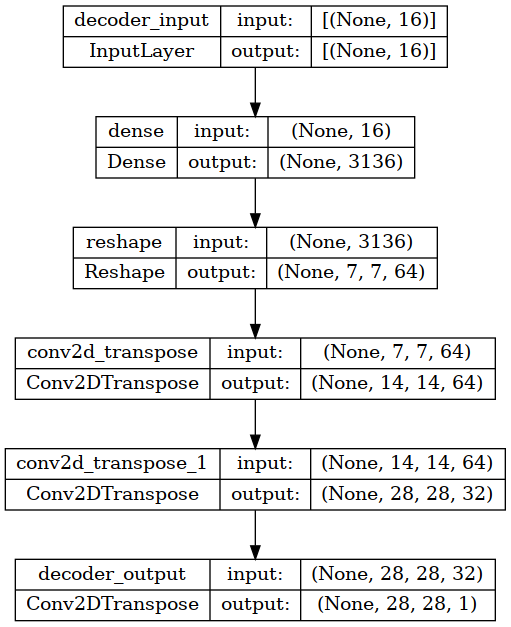

In [14]:
# instantiate the decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True)

In [19]:
# Autoencoder
# autoencoder = encoder + decoder

# instantiate autencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)),
                   name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                69008     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         108993    
                                                                 
Total params: 178001 (695.32 KB)
Trainable params: 178001 (695.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


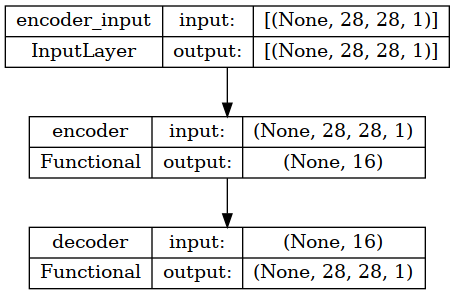

In [20]:
plot_model(autoencoder, to_file='autencoder.png', show_shapes=True)

In [22]:
# Mean Square Error(MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

In [27]:
# train the autoencoder
autoencoder.fit(x_train, x_train, validation_data=(x_test, x_test),
               epochs=1,
               batch_size=batch_size)

1875/1875 [==============================] - 34s 18ms/step - loss: 0.0081 - val_loss: 0.0081


In [28]:
# Predict the autoencoder output from the test data
x_decoded = autoencoder.predict(x_test)

313/313 [==============================] - 2s 7ms/step


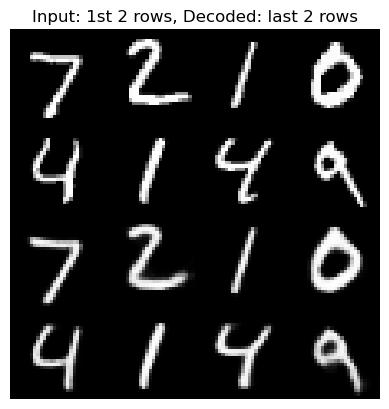

In [30]:
# display the first 8 test input and decoded images
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4,4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='grey')
plt.savefig('input_and_decoded.png')
plt.show()

we extracted and decoded the latent_dims from input on the downgraded dimensions using autoencoders ecnoder and decoder